In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
driver = pd.read_csv('datasets/driver_ids.csv')
ride = pd.read_csv('datasets/ride_ids.csv')
time = pd.read_csv('datasets/ride_timestamps.csv')

In [3]:
ride.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


# Cleaning/Reformatting Data Sets 

*Driver*

In [4]:
def driver_cleaner(df):
    df['driver_onboard_date'] = pd.to_datetime(df['driver_onboard_date']) # convert to date time for easier manipulation
    return df

In [5]:
enriched_driver = driver_cleaner(driver)
enriched_driver.head()

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29
1,007f0389f9c7b03ef97098422f902e62,2016-03-29
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23
4,01674381af7edd264113d4e6ed55ecda,2016-04-29


*Ride*

In [6]:
def ride_cleaner(df):    
    ride = df.copy()
    ride['ride_prime_time'] = ride['ride_prime_time']/100 # change to percentage 
    ride.columns = ['driver_id','ride_id','ride_distance (meters)',
                  'ride_duration (seconds)','ride_prime_time (percentage)'] # rename columns 
    ride['ride_distance (miles)'] = ride['ride_distance (meters)']/1609.344
    ride['ride_duration (minutes)'] = ride['ride_duration (seconds)']/60
    def cost_calculator(miles_column,minutes_column,prime_time_column,tax_rate = False):
        BASE_FARE = 2
        COST_PER_MILE = 1.15
        COST_PER_MINUTE = 0.22
        SERVICE_FEE = 1.75 
        TAX_RATE = 0.085 # CHANGE 
        fare = BASE_FARE + miles_column*COST_PER_MILE + minutes_column*COST_PER_MINUTE
        if tax_rate:
            cost = SERVICE_FEE + fare + fare*prime_time_column + fare*TAX_RATE
        else: 
            cost = SERVICE_FEE + fare + fare*prime_time_column
        return cost
    ride['cost w/o prime time'] = cost_calculator(ride['ride_distance (miles)'],ride['ride_duration (minutes)'],0)
    ride['cost w/ prime time'] = cost_calculator(ride['ride_distance (miles)'],ride['ride_duration (minutes)'],
                                                 ride['ride_prime_time (percentage)'])
    ride['cost w/ prime time and tax'] = cost_calculator(ride['ride_distance (miles)'],ride['ride_duration (minutes)'],
                                                 ride['ride_prime_time (percentage)'],True)
    def cost_regulator(x):
        MINIMUM_FARE = 5
        MAXIMUM_FARE = 400
        if x < MINIMUM_FARE:
            return MINIMUM_FARE
        elif x > MAXIMUM_FARE:
            return MAXIMUM_FARE 
        else:
            return x
    ride['cost w/ prime time'] = ride['cost w/ prime time'].apply(cost_regulator)
    ride['lyft profit'] = (ride['cost w/ prime time'] - 1.75)*.2 
    return ride

In [7]:
enriched_ride = ride_cleaner(ride)

enriched_ride.drop(['cost w/ prime time','ride_distance (meters)','ride_duration (seconds)'],axis=1).head()

,driver_id,ride_id,ride_prime_time (percentage),ride_distance (miles),ride_duration (minutes),cost w/o prime time,cost w/ prime time and tax,lyft profit
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,0.50,1.125303,5.450000,6.243099,8.871561,1.347930
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,0.00,2.089050,13.483333,9.118741,9.745084,1.473748
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,0.00,2.039340,9.533333,8.192575,8.740193,1.288515
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,0.25,40.564976,55.633333,62.639055,83.036889,15.222264
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,1.00,2.556942,13.716667,9.708150,18.342744,3.183260


*time*

In [8]:
def time_cleaner(df):
    time = df.copy()
    time['timestamp'] = pd.to_datetime(time['timestamp'])
    # change from 5 rows to 1 row with 5 data points 
    mod_time = time.pivot(index='ride_id', columns='event', values='timestamp').reset_index()
    # reorder columns to make more sense 
    mod_time = mod_time[['ride_id','requested_at','accepted_at','arrived_at','picked_up_at','dropped_off_at']]
    # how long a person had to wait before someone accepted their ride request
    mod_time['duration_request_to_accept'] = (mod_time['accepted_at']-mod_time['requested_at']).apply(lambda x: x.total_seconds())
    # how long it took driver to drive to location of person
    mod_time['duration_accept_to_arrive'] = (mod_time['arrived_at']-mod_time['accepted_at']).apply(lambda x: x.total_seconds())
    # how long the driver waited for the person to get into the car
    mod_time['duration_arrived_to_pickup'] = (mod_time['picked_up_at']-mod_time['arrived_at']).apply(
        lambda x: np.nan if x < pd.Timedelta(0) else x.total_seconds())
    # how long the actual trip was 
    mod_time['duration_ride'] = (mod_time['dropped_off_at']-mod_time['picked_up_at']).apply(lambda x: x.total_seconds())
    return mod_time

In [9]:
enriched_time = time_cleaner(time)
enriched_time.head()

event,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at,duration_request_to_accept,duration_accept_to_arrive,duration_arrived_to_pickup,duration_ride
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:19,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 09:44:33,2016-06-13 10:03:05,32.0,280.0,2.0,1112.0
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:21,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:26:18,2016-05-14 05:34:17,4.0,172.0,1.0,479.0
2,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:09,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:47:32,2016-05-16 15:54:18,5.0,255.0,3.0,406.0
3,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:36,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:35:15,2016-05-11 19:40:47,7.0,328.0,4.0,332.0
4,0000d9b24d8ccdd991b76258e616fa01,2016-04-26 18:11:38,2016-04-26 18:12:15,2016-04-26 18:16:52,2016-04-26 18:16:55,2016-04-26 18:24:14,37.0,277.0,3.0,439.0


## Merged Sets

In [10]:
enriched_ride_simple = enriched_ride[['driver_id','ride_id','ride_distance (miles)', 'ride_duration (minutes)', 
                               'ride_prime_time (percentage)','cost w/ prime time','lyft profit']]

there are 937 unique ID's in ride dataset and 937 unique ID's in driver dataset. However, only 854 of the unique ID's match between the two datasets 

In [11]:
matches = enriched_ride_simple.merge(enriched_driver, how = 'inner')
matches.head()

,driver_id,ride_id,ride_distance (miles),ride_duration (minutes),ride_prime_time (percentage),cost w/ prime time,lyft profit,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.125303,5.450000,0.50,8.489648,1.347930,2016-03-29
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089050,13.483333,0.00,9.118741,1.473748,2016-03-29
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2.039340,9.533333,0.00,8.192575,1.288515,2016-03-29
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,40.564976,55.633333,0.25,77.861319,15.222264,2016-03-29
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,2.556942,13.716667,1.00,17.666301,3.183260,2016-03-29


We have 185891 rides still with additional driver information, which is not bad (originally we had 193502 rides). The next following dataframes are the items that have missing info (whether it be missing driver information or drivers with no documented rides)

In [12]:
overall = enriched_ride_simple.merge(enriched_driver, how = 'outer')
# we don't have driver information for these data points 
no_driver_info = overall[overall['driver_onboard_date'].isnull()]
no_driver_info.head()

,driver_id,ride_id,ride_distance (miles),ride_duration (minutes),ride_prime_time (percentage),cost w/ prime time,lyft profit,driver_onboard_date
3687,056175954c78be4c4de7e80167b7e1f9,0488679087be6f76612dfc9ecba227e5,1.285617,6.783333,0.0,6.720793,0.994159,NaT
3688,056175954c78be4c4de7e80167b7e1f9,060d6b3e4916e1aec8cc1e746f6fd87e,1.048875,6.150000,0.0,6.309206,0.911841,NaT
3689,056175954c78be4c4de7e80167b7e1f9,075f23b3edafd5020837b14b79d7b9e8,8.010096,21.933333,0.0,17.786944,3.207389,NaT
3690,056175954c78be4c4de7e80167b7e1f9,0d4727f995ee19c0ed4654b0a5a82176,1.282510,7.216667,0.0,6.812553,1.012511,NaT
3691,056175954c78be4c4de7e80167b7e1f9,0f1f969a4ddc30c8c9c14509156e3149,2.491698,15.733333,0.0,10.076787,1.665357,NaT


In [13]:
overall = enriched_ride_simple.merge(enriched_driver, how = 'outer')
# these drivers dont have documented rides 
driver_that_has_no_rides = overall[overall['ride_id'].isnull()]
driver_that_has_no_rides.head()

,driver_id,ride_id,ride_distance (miles),ride_duration (minutes),ride_prime_time (percentage),cost w/ prime time,lyft profit,driver_onboard_date
193502,01788cf817698fe68eaecd7eb18b2f72,NaN,NaN,NaN,NaN,NaN,NaN,2016-05-06
193503,133faf644d5cfee9460b87eea4367f92,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-08
193504,13fe6713788e9b63f57950320f260512,NaN,NaN,NaN,NaN,NaN,NaN,2016-05-05
193505,146cd888491dd0f348575244f5bbc24e,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-16
193506,1585fa96f0818e8f4d1cf826b332fda4,NaN,NaN,NaN,NaN,NaN,NaN,2016-05-06


Now we can go ahead and merge with the time data so that we have a full dataset.

In [14]:
final_matches = matches.merge(enriched_time, how = 'inner')
final_matches.head()

,driver_id,ride_id,ride_distance (miles),ride_duration (minutes),ride_prime_time (percentage),cost w/ prime time,lyft profit,driver_onboard_date,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at,duration_request_to_accept,duration_accept_to_arrive,duration_arrived_to_pickup,duration_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.125303,5.450000,0.50,8.489648,1.347930,2016-03-29,2016-04-23 02:13:50,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:16:40,2016-04-23 02:22:07,25.0,141.0,4.0,327.0
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089050,13.483333,0.00,9.118741,1.473748,2016-03-29,2016-03-29 19:00:49,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:04:01,2016-03-29 19:17:30,3.0,185.0,4.0,809.0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2.039340,9.533333,0.00,8.192575,1.288515,2016-03-29,2016-06-21 11:56:31,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:01:35,2016-06-21 12:11:07,8.0,293.0,3.0,572.0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,40.564976,55.633333,0.25,77.861319,15.222264,2016-03-29,2016-05-19 09:15:29,2016-05-19 09:15:33,2016-05-19 09:18:20,2016-05-19 09:18:20,2016-05-19 10:13:58,4.0,167.0,0.0,3338.0
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,2.556942,13.716667,1.00,17.666301,3.183260,2016-03-29,2016-04-20 22:05:30,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:07:02,2016-04-20 22:20:45,2.0,91.0,NaN,823.0


We have 184209 data points with driver, ride, and time information, which is still a lot of data! We might go back later on to see what can be done about rides missing time data, but time data missing rides is relatively not useful.

## Answering the Questions

In [15]:
# LIFETIME VALUE AVERAGES 

In [16]:
def work_expectancy_df(df):
    part_one = pd.DataFrame(df.groupby('driver_id')['driver_onboard_date'].min()).reset_index()
    part_two = pd.DataFrame(df.groupby('driver_id')['dropped_off_at'].max()).reset_index()
    important_times = part_one.merge(part_two)
    important_times['worktime_expectancy'] = important_times['dropped_off_at']-important_times['driver_onboard_date']
    def date_conversion(x):
        return x.days
    important_times['worktime_expectancy (days)'] = important_times['worktime_expectancy'].apply(date_conversion)
    important_times = important_times[['driver_id','worktime_expectancy (days)']]
    return important_times

In [17]:
summary_of_worktime = work_expectancy_df(final_matches)
summary_of_worktime.head()

,driver_id,worktime_expectancy (days)
0,002be0ffdc997bd5c50703158b7c2491,86
1,007f0389f9c7b03ef97098422f902e62,85
2,011e5c5dfc5c2c92501b8b24d47509bc,68
3,0152a2f305e71d26cc964f8d4411add9,64
4,01674381af7edd264113d4e6ed55ecda,56


In [18]:
overall_costs = pd.DataFrame(final_matches.groupby('driver_id')[['cost w/ prime time','lyft profit']]
                             .sum()).reset_index()

In [19]:
summary = summary_of_worktime.merge(overall_costs)
summary.head()

,driver_id,worktime_expectancy (days),cost w/ prime time,lyft profit
0,002be0ffdc997bd5c50703158b7c2491,86,3560.922468,615.234494
1,007f0389f9c7b03ef97098422f902e62,85,321.494698,53.448940
2,011e5c5dfc5c2c92501b8b24d47509bc,68,482.427855,84.585571
3,0152a2f305e71d26cc964f8d4411add9,64,2610.868733,455.323747
4,01674381af7edd264113d4e6ed55ecda,56,5381.091520,944.968304


In [20]:
number_of_drives = final_matches.groupby('driver_id')[['ride_id']].count().reset_index()
summary_extended = summary.merge(number_of_drives)
def group_decider(x):
    if x < 100:
        return 0
    else: 
        return 1 
summary_extended['group'] = summary_extended['ride_id'].apply(group_decider)
summary_extended.columns = ['driver_id','worktime_expectancy (days)','cost w/ prime time', 'lyft profit', 'number drives', 'group']
summary_extended.head()

,driver_id,worktime_expectancy (days),cost w/ prime time,lyft profit,number drives,group
0,002be0ffdc997bd5c50703158b7c2491,86,3560.922468,615.234494,277,1
1,007f0389f9c7b03ef97098422f902e62,85,321.494698,53.448940,31,0
2,011e5c5dfc5c2c92501b8b24d47509bc,68,482.427855,84.585571,34,0
3,0152a2f305e71d26cc964f8d4411add9,64,2610.868733,455.323747,191,1
4,01674381af7edd264113d4e6ed55ecda,56,5381.091520,944.968304,375,1


In [21]:
to_be_merged_w_final_matches = summary_extended[['driver_id','worktime_expectancy (days)','number drives','group']]

In [22]:
combined_lyft_dataset = final_matches.merge(to_be_merged_w_final_matches)
combined_lyft_dataset.to_csv('datasets/combined_lyft_dataset.csv')

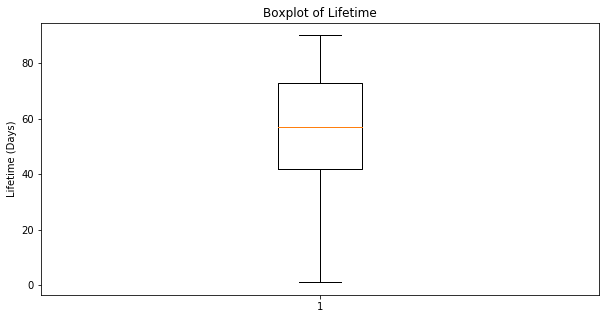

In [23]:
# NO OUTLIERS, DON'T NEED TO GET RID OF ANY OF THE WORKTIME EXPECTANCIES
f, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Lifetime (Days)')
ax.set_title('Boxplot of Lifetime')
ax.boxplot(summary_extended['worktime_expectancy (days)'],showfliers = True);

In [24]:
stats.skew(summary_extended['worktime_expectancy (days)'],bias = True) # negative skewness, skewed left 
# because absolute value of skewness is less than .5, we can say that the data is relatively normal 
# https://support.minitab.com/en-us/minitab/18/help-and-how-to/statistics/basic-statistics/supporting-topics/data-concepts/how-skewness-and-kurtosis-affect-your-distribution/

-0.482987961197601

In [25]:
stats.kurtosis(summary_extended['worktime_expectancy (days)']) 
# less outlier prone 

-0.5571842645119176

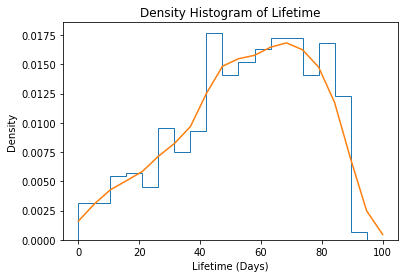

In [26]:
n, x, _ = plt.hist(summary_extended['worktime_expectancy (days)'],bins=np.linspace(0, 100, 20),histtype=u'step',density=True);
density = stats.gaussian_kde(summary_extended['worktime_expectancy (days)'])
plt.plot(x, density(x))
plt.xlabel('Lifetime (Days)')
plt.title('Density Histogram of Lifetime')
plt.ylabel('Density');

In [27]:
combined_lyft_dataset['total waiting time'] = combined_lyft_dataset['duration_request_to_accept']+combined_lyft_dataset['duration_accept_to_arrive']

In [28]:
def get_date(x):
    return x.days
combined_lyft_dataset['days since onboard ride occurred'] = (
    combined_lyft_dataset['dropped_off_at']-combined_lyft_dataset['driver_onboard_date']).apply(get_date)

In [29]:
drive_numbers = pd.DataFrame(combined_lyft_dataset.groupby('driver_id')['days since onboard ride occurred'].value_counts())
drive_numbers.columns = ['number of drives that occurred that day']
drive_numbers = drive_numbers.reset_index()
drive_numbers = drive_numbers.sort_values(['driver_id','days since onboard ride occurred'])
drive_numbers.head()

,driver_id,days since onboard ride occurred,number of drives that occurred that day
17,002be0ffdc997bd5c50703158b7c2491,0,6
7,002be0ffdc997bd5c50703158b7c2491,2,8
18,002be0ffdc997bd5c50703158b7c2491,3,6
19,002be0ffdc997bd5c50703158b7c2491,4,6
10,002be0ffdc997bd5c50703158b7c2491,7,7


In [30]:
summary_extended.describe()

,worktime_expectancy (days),cost w/ prime time,lyft profit,number drives,group
count,837.000000,837.000000,837.000000,837.000000,837.000000
mean,55.105137,2979.856480,518.942443,220.082437,0.597372
std,21.726518,2416.910584,421.944259,178.180347,0.490720
min,1.000000,25.691307,4.088261,3.000000,0.000000
25%,42.000000,618.243078,108.684564,44.000000,0.000000
50%,57.000000,2959.138298,513.427660,224.000000,1.000000
75%,73.000000,4476.529992,780.960044,330.000000,1.000000
max,90.000000,12350.274880,2186.924776,919.000000,1.000000


In [31]:
# Monday is 0 and Sunday is 6
def get_weekday(x):
    return x.weekday()
combined_lyft_dataset['weekday number onboard'] = combined_lyft_dataset['driver_onboard_date'].apply(get_weekday)

The average amount of days worked is 57 days (the median).

In [32]:
# determining line of best fit

In [33]:
best_fit_df = combined_lyft_dataset.groupby('driver_id').agg({'worktime_expectancy (days)':'mean',
                                       'lyft profit':'sum',
                                      'number drives':'mean',
                                       #'driver_onboard_date': 'sum',
                                      'total waiting time':'median'}).reset_index() # median because large positive skewness for total waiting time 
#[['worktime_expectancy (days)','lyft profit']].mean().reset_index()

In [34]:
best_fit_df.head()

,driver_id,worktime_expectancy (days),lyft profit,number drives,total waiting time
0,002be0ffdc997bd5c50703158b7c2491,86,615.234494,277,157.0
1,007f0389f9c7b03ef97098422f902e62,85,53.448940,31,172.0
2,011e5c5dfc5c2c92501b8b24d47509bc,68,84.585571,34,207.0
3,0152a2f305e71d26cc964f8d4411add9,64,455.323747,191,226.0
4,01674381af7edd264113d4e6ed55ecda,56,944.968304,375,177.0


In [35]:
best_fit_df.mean()

worktime_expectancy (days)     55.105137
lyft profit                   518.942443
number drives                 220.082437
total waiting time            235.396057
dtype: float64

In [36]:
def line_of_best_fit_stuff(x_thing, y_thing):
    linear_model_scores = []
    for i in range(200):
        x = x_thing
        y = y_thing
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=0.30)
        x_train= x_train.reshape(-1, 1)
        y_train= y_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        sample = [] 
        for j in range(1,14):
            poly_features = PolynomialFeatures(degree=j)
            X_train_poly = poly_features.fit_transform(x_train)
            poly_model = LinearRegression()
            poly_model.fit(X_train_poly, y_train)
            # y_train_predicted = poly_model.predict(X_train_poly)
            y_test_predict = poly_model.predict(poly_features.fit_transform(x_test))
            #print('prediction for 55: '+str(poly_model.predict(poly_features.fit_transform(np.array(55).reshape(-1, 1)))))
            rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
            r2_test = r2_score(y_test, y_test_predict)
            sample.append(r2_test)
        linear_model_scores.append(sample)
    scores = pd.DataFrame(linear_model_scores)
    scores.columns = ['degree_1','degree_2','degree_3','degree_4','degree_5','degree_6','degree_7',
                      'degree_8','degree_9','degree_10','degree_11','degree_12','degree_13']
    return scores

517.8767075059664
537.2419105264
548.2274789957843
583.5710785735906
605.7994284365132
615.939071152237
637.0380887667305
degree_1     0.264462
degree_2     0.264864
degree_3     0.268050
degree_4     0.279173
degree_5     0.283223
degree_6     0.285263
degree_7     0.286492
degree_8     0.285562
degree_9     0.285478
degree_10    0.284467
degree_11    0.284560
degree_12    0.283969
degree_13    0.284057
dtype: float64


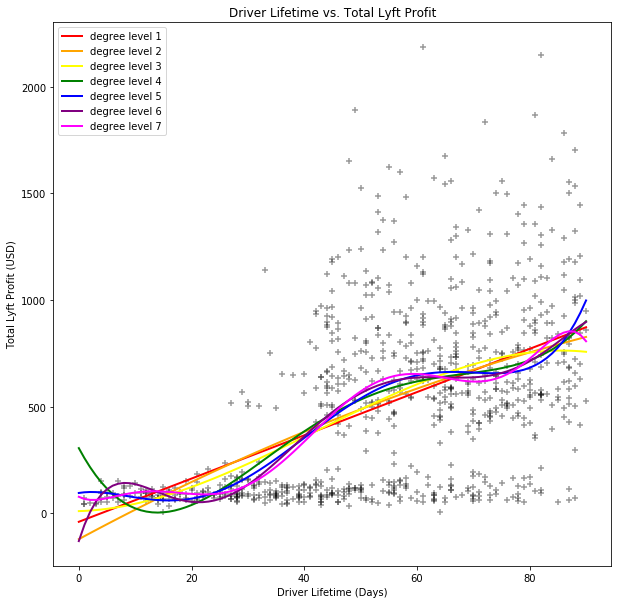

In [37]:
import sympy
from sympy import S, symbols
f, ax = plt.subplots(figsize=(10, 10))
x=best_fit_df['worktime_expectancy (days)']
max_thing = x.max()
y=best_fit_df['lyft profit']
ax.scatter(x=best_fit_df['worktime_expectancy (days)'],y=best_fit_df['lyft profit'], marker = '+', color = 'black',
           alpha = .4)
colors = ['red','orange','yellow','green','blue','purple','magenta']
for i in range(len(colors)):
    poly = np.polyfit(x, y, i+1)
    x2 = range(max_thing+1)#np.linspace(0, 100,1)#max_thing, max_thing)
    y2 = np.polyval(poly, x2)
    ax.plot(x2, y2, lw=2, color=colors[i],label= 'degree level '+str(i+1)) #poly2latex(poly))#
    print(y2[55])
    eq_latex = sympy.printing.latex(poly)
kms = line_of_best_fit_stuff(np.array(x),np.array(y))
print(kms.mean())
ax.legend(loc='upper left')
ax.set_xlabel('Driver Lifetime (Days)')
ax.set_ylabel('Total Lyft Profit (USD)')
#ax.set_ylim(bottom=y.min(),top = y.max())
#ax.set_xlim(left=x.min(), right = x.max())
ax.set_title('Driver Lifetime vs. Total Lyft Profit');

219.62470718515843
225.8039322017437
230.41462649406805
244.61077713191852
252.44072181293433
257.40982369231034
266.796940126139
degree_1     0.278780
degree_2     0.278169
degree_3     0.280468
degree_4     0.291660
degree_5     0.293587
degree_6     0.298319
degree_7     0.300050
degree_8     0.299234
degree_9     0.299576
degree_10    0.298762
degree_11    0.298861
degree_12    0.298187
degree_13    0.298146
dtype: float64


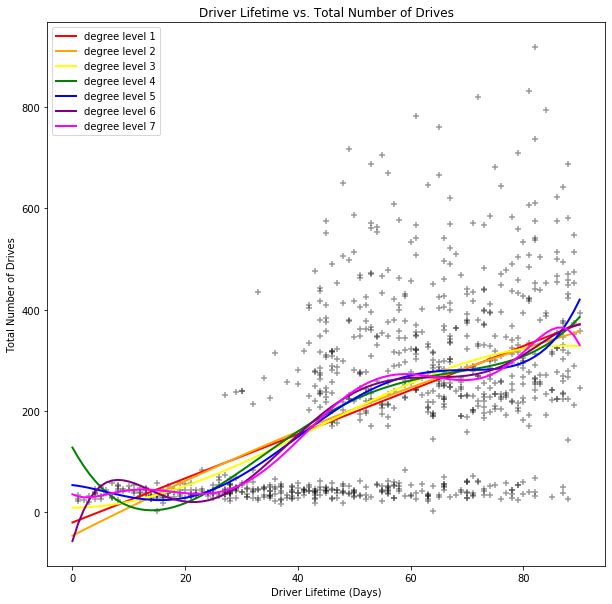

In [38]:
f, ax = plt.subplots(figsize=(10, 10))
x=best_fit_df['worktime_expectancy (days)']
max_thing = x.max()
y=best_fit_df['number drives']
ax.scatter(x=x,y=y, marker = '+', color = 'black', alpha = .4)
colors = ['red','orange','yellow','green','blue','purple','magenta']
for i in range(len(colors)):
    poly = np.polyfit(x, y, i+1)
    x2 = range(max_thing+1)#max_thing, max_thing)
    y2 = np.polyval(poly, x2)
    ax.plot(x2, y2, lw=2, color=colors[i],label= 'degree level '+str(i+1))#'degree level '+str(i+1))
    #print(poly2latex(poly))
    print(y2[55])
    eq_latex = sympy.printing.latex(poly)
kms = line_of_best_fit_stuff(np.array(x),np.array(y))
print(kms.mean())
ax.legend(loc='upper left')
ax.set_xlabel('Driver Lifetime (Days)')
ax.set_ylabel('Total Number of Drives')
ax.set_title('Driver Lifetime vs. Total Number of Drives');

235.44634852815648
238.2457935508242
236.46446119339427
234.1108588890671
236.32118199270167
235.1736168729173
234.7979522073032
degree_1     0.007748
degree_2     0.006424
degree_3     0.006494
degree_4     0.005296
degree_5     0.003517
degree_6     0.001337
degree_7    -0.001083
degree_8     0.001168
degree_9     0.002344
degree_10    0.003316
degree_11    0.001642
degree_12    0.001175
degree_13    0.001692
dtype: float64


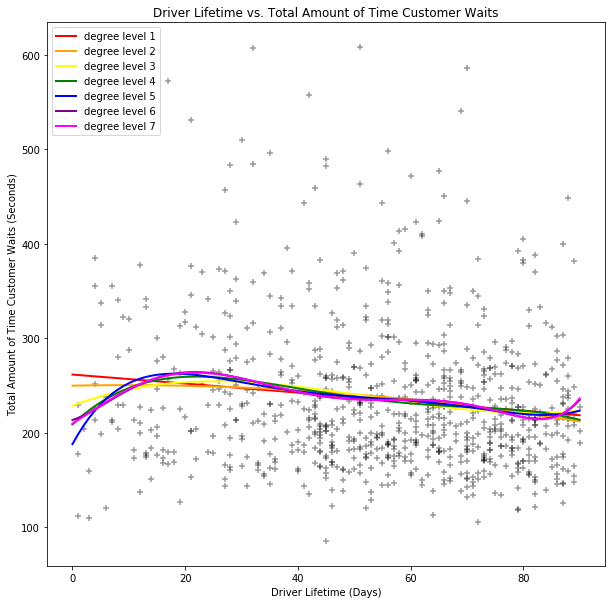

In [39]:
f, ax = plt.subplots(figsize=(10, 10))
x=best_fit_df['worktime_expectancy (days)']
y=best_fit_df['total waiting time']
ax.scatter(x=x,y=y, marker = '+', color = 'black', alpha = .4)

colors = ['red','orange','yellow','green','blue','purple','magenta']
for i in range(len(colors)):
    poly = np.polyfit(x, y, i+1)
    x2 = range(max_thing+1)#max_thing, max_thing)
    y2 = np.polyval(poly, x2)
    ax.plot(x2, y2, lw=2, color=colors[i],label= 'degree level '+str(i+1))#'degree level '+str(i+1))
    #print(poly2latex(poly))
    print(y2[55])
    eq_latex = sympy.printing.latex(poly)
kms = line_of_best_fit_stuff(np.array(x),np.array(y))
print(kms.mean())
ax.legend(loc='upper left')
ax.set_xlabel('Driver Lifetime (Days)')
ax.set_ylabel('Total Amount of Time Customer Waits (Seconds)')
ax.set_title('Driver Lifetime vs. Total Amount of Time Customer Waits');

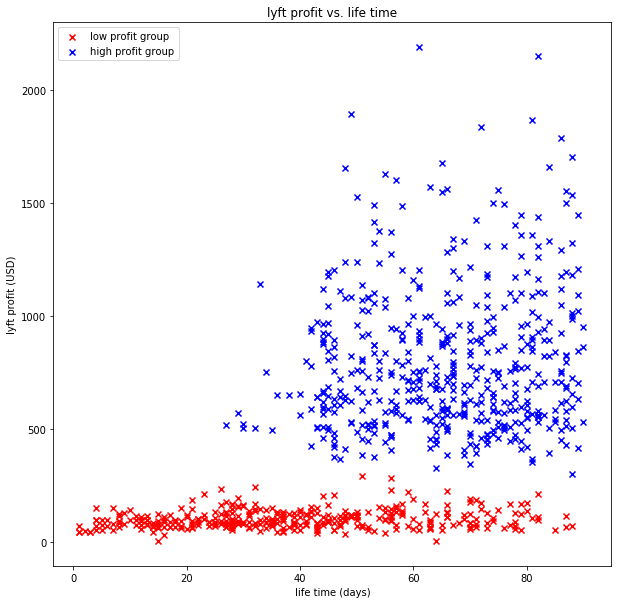

In [40]:
group_one = summary_extended[summary_extended['group']==0]
group_two = summary_extended[summary_extended['group']==1]
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=group_one['worktime_expectancy (days)'],y=group_one['lyft profit'], marker = 'x',color='red',label='low profit group')
ax.scatter(x=group_two['worktime_expectancy (days)'],y=group_two['lyft profit'], marker = 'x',color='blue',label='high profit group')
ax.set_xlabel('life time (days)')
ax.set_ylabel('lyft profit (USD)')
ax.legend()

#ax.plot([0, summary['worktime_expectancy (days)'].max()], [70, 70], 'k-', lw=2)
ax.set_title('lyft profit vs. life time');

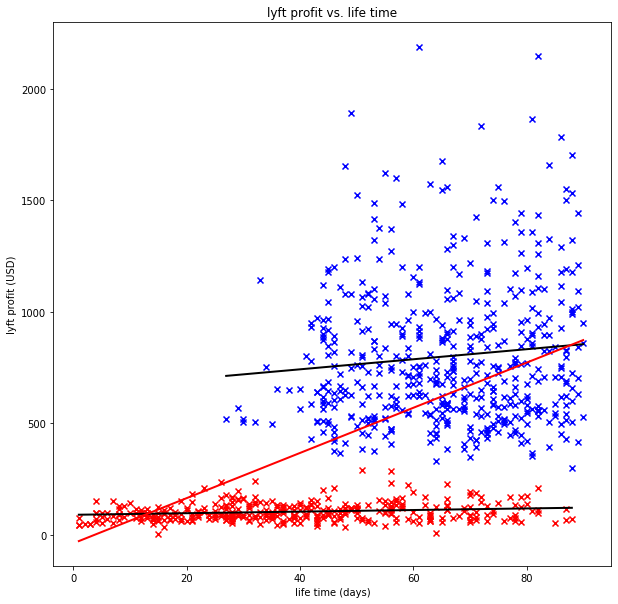

In [41]:
group_one = summary_extended[summary_extended['group']==0]
group_two = summary_extended[summary_extended['group']==1]
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=group_one['worktime_expectancy (days)'],y=group_one['lyft profit'], marker = 'x',color = 'red')
ax.scatter(x=group_two['worktime_expectancy (days)'],y=group_two['lyft profit'], marker = 'x',color= 'blue')
ax.set_xlabel('life time (days)')
ax.set_ylabel('lyft profit (USD)')

# ax.plot([0, summary['worktime_expectancy (days)'].max()], [100, 100], 'k-', lw=2)


ax.set_title('lyft profit vs. life time');


ax.plot(np.unique(group_one['worktime_expectancy (days)']), np.poly1d(
    np.polyfit(group_one['worktime_expectancy (days)'], group_one['lyft profit'], 1))(
    np.unique(group_one['worktime_expectancy (days)'])), color='black', linewidth = '2');
ax.plot(np.unique(group_two['worktime_expectancy (days)']), np.poly1d(
    np.polyfit(group_two['worktime_expectancy (days)'], group_two['lyft profit'], 1))(
    np.unique(group_two['worktime_expectancy (days)'])),color='black', linewidth = '2');
ax.plot(np.unique(summary_extended['worktime_expectancy (days)']), np.poly1d(
    np.polyfit(summary_extended['worktime_expectancy (days)'], summary_extended['lyft profit'], 1))(
    np.unique(summary_extended['worktime_expectancy (days)'])),color='red', linewidth = '2');

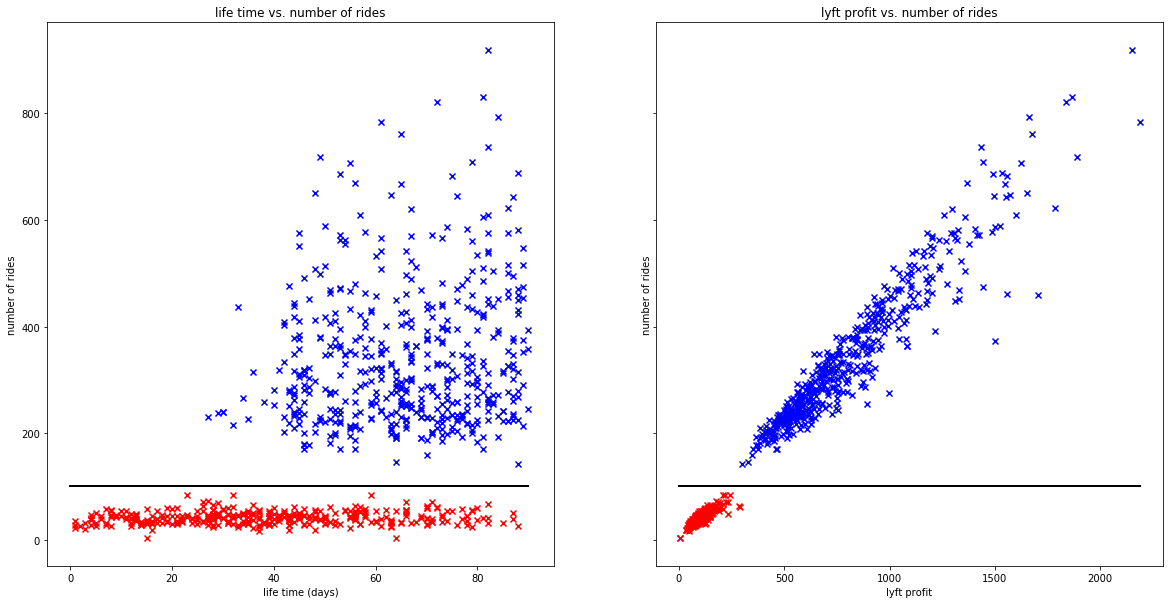

In [42]:
group_one = summary_extended[summary_extended['group']==0]
group_two = summary_extended[summary_extended['group']==1]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
ax1.scatter(x=group_one['worktime_expectancy (days)'],y=group_one['number drives'], marker = 'x',color='red')
ax1.scatter(x=group_two['worktime_expectancy (days)'],y=group_two['number drives'], marker = 'x',color='blue')
ax1.plot([0, summary_extended['worktime_expectancy (days)'].max()], [100, 100], 'k-', lw=2)
ax1.set_xlabel('life time (days)')
ax1.set_ylabel('number of rides')
ax1.set_title('life time vs. number of rides');

ax2.scatter(x = group_one['lyft profit'], y = group_one['number drives'], marker = 'x',color='red')
ax2.scatter(x = group_two['lyft profit'], y = group_two['number drives'], marker = 'x',color='blue')
ax2.plot([0, summary_extended['lyft profit'].max()], [100, 100], 'k-', lw=2)
ax2.set_xlabel('lyft profit')
ax2.set_ylabel('number of rides')
ax2.set_title('lyft profit vs. number of rides');



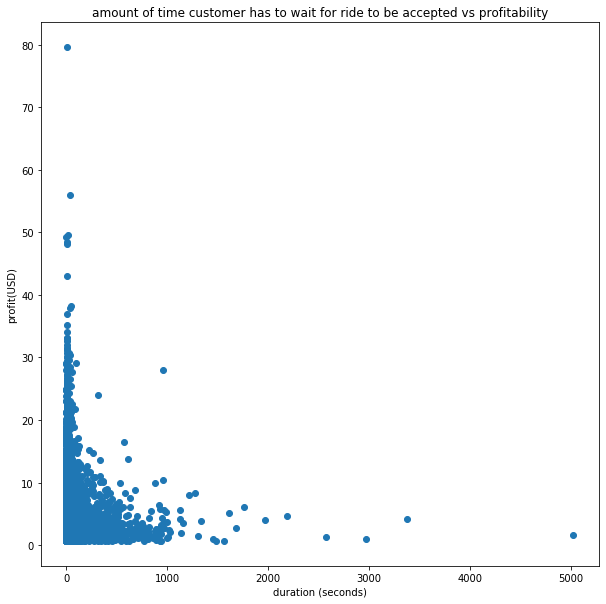

In [43]:
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=combined_lyft_dataset['duration_request_to_accept'],y=combined_lyft_dataset['lyft profit'])
ax.set_xlabel('duration (seconds)')
ax.set_ylabel('profit(USD)')
ax.set_title('amount of time customer has to wait for ride to be accepted vs profitability');

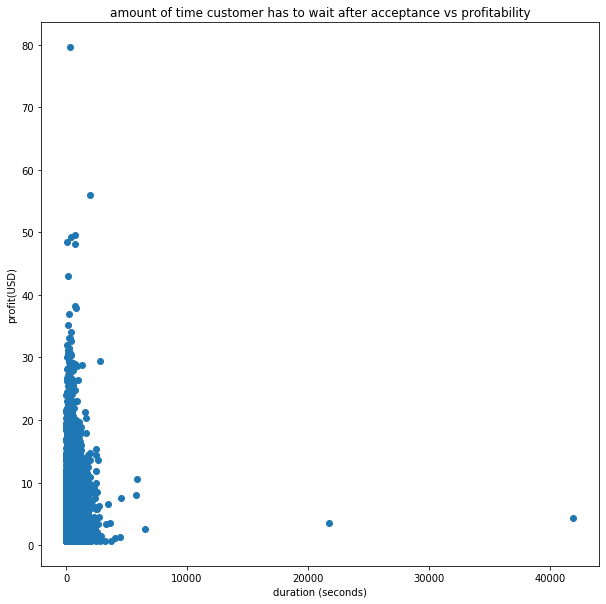

In [44]:
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=combined_lyft_dataset['duration_accept_to_arrive'],y=combined_lyft_dataset['lyft profit'])
ax.set_xlabel('duration (seconds)')
ax.set_ylabel('profit(USD)')
ax.set_title('amount of time customer has to wait after acceptance vs profitability');

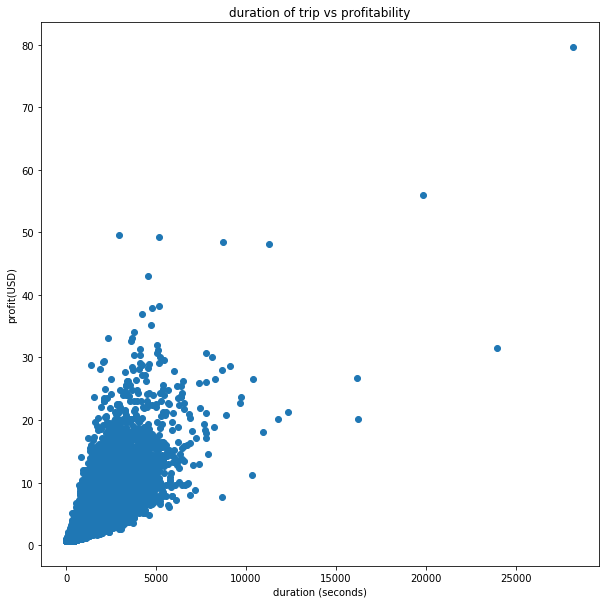

In [45]:
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=combined_lyft_dataset['duration_ride'],y=combined_lyft_dataset['lyft profit'])
ax.set_xlabel('duration (seconds)')
ax.set_ylabel('profit(USD)')
ax.set_title('duration of trip vs profitability');